In [23]:
!git clone https://github.com/LeonardoMonte/CrossDomainMineracao2019.2.git
path = 'CrossDomainMineracao2019.2/database/'
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import pickle
import spacy
import unicodedata
import re
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pickle
from collections import defaultdict
from scipy.stats import friedmanchisquare
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pandas as pd
from nltk.corpus import stopwords
import time
from sklearn.metrics import confusion_matrix
import os
from tqdm import tqdm
import math
import nltk
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')



fatal: destination path 'CrossDomainMineracao2019.2' already exists and is not an empty directory.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Functions

In [0]:
def read(address):
    arq = open(address, 'rb')
    return pickle.load(arq)


def save_pickle(address, element):
    arq = open(address, 'wb')
    pickle.dump(element, arq)


def save_data_frame(s, name):
    s.to_csv(name + '.csv', index=False)

### MUDAR FONTE
def return_domain(domain_name):
    return read("drive/My Drive/sa/DATASET/"+domain_name+".pk")

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

neg_words = ['not', 'no', "n't", "never", "nothing"]
def tokenize(doc):
    stop = stopwords.words('english')
    x = []
    t = word_tokenize(doc)
    for a in t:
        a = a.lower()
        if a in "n't":
                x.append("not")
        elif a not in stop or a in neg_words:
            if a.isalpha() and len(a) > 1:
                x.append(WordNetLemmatizer().lemmatize(a))
    return x
  

# The input is a tokenize document
pos_import = ["NN", "VB", "JJ", "RB"]


def pos_filter(token_doc,nword):
    pos = nltk.pos_tag(token_doc)
    new_t = []
    jump = -1
    for p in pos:
        k = [True if po in p[1] else False for po in pos_import]
        if any(k) or ((p[0] in neg_words)):
            if p[0] in neg_words and nword:
                n, jump = neg_affect(p, pos, 4)
                if n != "":
                    new_t.append(n)
            else:
                if pos.index(p) == jump:
                    pass
                else:
                    new_t.append(p[0])

    return new_t
  
# w is window
def neg_affect(word, pos, w):
    neg_pos = ["VB", "JJ", "RB"]
    i = pos.index(word)
    if word[0] == "no":
        try:
            if "NN" in pos[i + 1][1]:
                n = pos[i + 1][0] + "_NOT"
                return n, i + 1
        except:
            return "", -1
    else:
        for j in range(i + 1, i + w):
            try:
                k = [True if po in pos[j][1] else False for po in neg_pos]
                if any(k):
                    n = pos[j][0] + "_NOT"
                    return n, j
                elif pos[j][1] in punct:
                    return "", -1
            except:
                return "", -1
    return "", -1

def n_gr(token_doc):
    new_token = []
    for i in range(len(token_doc)):
        if i < (len(token_doc) - 1):
            new_token.append(token_doc[i])
            bi_gram = "%s__%s" % (token_doc[i], token_doc[i + 1])
            new_token.append(bi_gram)
    return new_token

def pipeline(doc):
    t = tokenize(doc)
    nt = pos_filter(t,True)
    nt_gram = n_gram(nt)
    return nt_gram

  

def setofwords(datapipeline):
  words = []
  for doc in datapipeline:
    for word in doc:
      words.append(word)

  words = list(set(words))

  return words

def word_frequency(all_doc):
  dic = {}
  vocab = []
 
  for token in all_doc:
    for w in token:
      if w in vocab:
        dic[w] += 1
      else:
        vocab.append(w)
        dic[w] = 1
  return dic

def bow_bin(token_rev,vocab):
  bag = []
  bag.append(vocab)
  doc = sorted(set(vocab))
  for doc in token_rev:
    val = np.zeros(len(vocab))
    for w in doc:
      i = vocab.index(w)
      val[i] = 1
    bag.append(val)
  return bag

def word_frequency(all_doc):
  dic = {}
  vocab = []
 
  for token in all_doc:
    for w in token:
      if w in vocab:
        dic[w] += 1
      else:
        vocab.append(w)
        dic[w] = 1
  return dic

def thr_lim(all_doc,thr):
  dic = word_frequency(all_doc)
  new_rev = []
  for i in list(dic):
    if dic[i] < thr:
      del(dic[i])
  for doc in all_doc:
    new = []
    for w in doc:
      try:
        dic[w]
        new.append(w)
      except:
        pass
    new_rev.append(new)
    
  return new_rev,dic

def amostra_estrat(tam , df , classe):
    classes = df[classe].unique()
    qtde_por_classe = round(tam / len(classes))
    amostras_por_classe = []
    for c in classes:
        indices_c = df[classe] == c
        obs_c = df[indices_c]
        amostra_c = obs_c.sample(qtde_por_classe)
        amostras_por_classe.append(amostra_c)
    amostra_estratificada = pd.concat(amostras_por_classe)
    return amostra_estratificada

def preprocess(token_rev, nword, pos, ng, thr):
  prepData = []
  
  for doc in (token_rev):
    prepData.append(selecPipe(doc, nword, pos, ng))
  if thr > 0:
    prepData, wordFreq = thr_lim(prepData,thr)
  else:
    wordFreq = word_frequency(prepData)
  return prepData, wordFreq

def selecPipe(doc, nword, pos, ng):
  t = tokenize(doc)
  if pos == True:
    t = pos_filter(t,nword) 
  if ng == True:
    t = n_gr(t)
  return t 

##### LOAD #####

# loading the datasets from the Git repositiry
def loadpreprocess(path,estra,tr,nword = True, pos = True, ng = True):

  books = read(path+'books.pk')
  dvd = read(path+'dvd.pk')
  electronics = read(path+'electronics.pk')
  kitchen = read(path+'kitchen.pk')

  frames1 = [pd.DataFrame(books[0]),pd.DataFrame(books[1])]
  booksnew = pd.concat(frames1,axis = 1, ignore_index=True)

  frames2 = [pd.DataFrame(dvd[0]),pd.DataFrame(dvd[1])]
  dvdnew = pd.concat(frames2,axis = 1, ignore_index=True)

  frames3 = [pd.DataFrame(electronics[0]),pd.DataFrame(electronics[1])]
  electronicsnew = pd.concat(frames3,axis = 1, ignore_index=True)

  frames4 = [pd.DataFrame(kitchen[0]),pd.DataFrame(kitchen[1])]
  kitchennew = pd.concat(frames4,axis = 1, ignore_index=True)


  booksnew = amostra_estrat(estra , booksnew , 1)
  dvdnew = amostra_estrat(estra , dvdnew , 1)
  electronicsnew = amostra_estrat(estra , electronicsnew , 1)
  kitchennew = amostra_estrat(estra , kitchennew , 1)

  books[0],books[1] = list(booksnew[0]),list(booksnew[1])
  dvd[0],dvd[1] = list(dvdnew[0]),list(dvdnew[1])
  electronics[0],electronics[1] = list(electronicsnew[0]),list(electronicsnew[1])
  kitchen[0],kitchen[1] = list(kitchennew[0]),list(kitchennew[1])


  #### END LOAD ####

  ##### PIPILINE PRE PROCESING ###

  bookspipeline,_ = preprocess(books[0], nword, pos, ng, tr)
  dvdpipeline,_ = preprocess(dvd[0], nword, pos, ng, tr)
  electronicspipeline,_ = preprocess(electronics[0], nword, pos, ng, tr)
  kitchenpipeline,_ = preprocess(kitchen[0], nword, pos, ng, tr)

  booksbow = np.array(bow_bin(bookspipeline,setofwords(bookspipeline)))
  dvdbow = np.array(bow_bin(dvdpipeline,setofwords(dvdpipeline)))
  electronicsbow = np.array(bow_bin(electronicspipeline,setofwords(electronicspipeline)))
  kitchenbow = np.array(bow_bin(kitchenpipeline,setofwords(kitchenpipeline)))

  books[0],books[1] = booksbow,np.array(books[1])
  dvd[0],dvd[1] = dvdbow,np.array(dvd[1])
  electronics[0],electronics[1] = electronicsbow,np.array(electronics[1])
  kitchen[0],kitchen[1] = kitchenbow,np.array(kitchen[1])

  books = [books[0][1:].astype(np.float),books[1].astype(np.float)]
  dvd = [dvd[0][1:].astype(np.float),dvd[1].astype(np.float)]
  electronics = [electronics[0][1:].astype(np.float),electronics[1].astype(np.float)]
  kitchen = [kitchen[0][1:].astype(np.float),kitchen[1].astype(np.float)]

  return books,dvd,electronics,kitchen


def kfoldexperiment(kvalue,kseed,ite,bd,bdclass,databasename, cmatrix = True):

  kfold = KFold(kvalue, True, kseed)

  naive = GaussianNB()
  svmrbf = SVC(kernel='rbf' , gamma='scale')
  logRegre = LogisticRegression(solver='lbfgs')

  if cmatrix:
    svmmatrix = []
    logmatrix = []
    naivematrix = []

  svmrbfarray = []
  logRegrearray = []
  naivearray = []

  svmrbftime = []
  logRegretime = []
  naivetime = []

  for x in range(ite):

    c = kfold.split(bd)

    for train_index, test_index in c:

      noclass_train, noclass_test = bd[train_index], bd[test_index]
      class_train, class_test = bdclass[train_index], bdclass[test_index]

      naivestart = time.time()
      naive.fit(noclass_train,class_train)
      naivearray.append(naive.score(noclass_test, class_test))

      if cmatrix:
        naivematrix.append(confusion_matrix(class_test, naive.predict(noclass_test)))

      naiveend = time.time()
      naivetime.append(naiveend - naivestart)

      logRegrestart = time.time()
      logRegre.fit(noclass_train,class_train)
      logRegrearray.append(logRegre.score(noclass_test,class_test))

      if cmatrix:
        logmatrix.append(confusion_matrix(class_test, logRegre.predict(noclass_test)))

      logRegreend = time.time()
      logRegretime.append(logRegreend - logRegrestart)

      svmrbfstart = time.time()
      svmrbf.fit(noclass_train,class_train)
      svmrbfarray.append(svmrbf.score(noclass_test, class_test))

      if cmatrix:
        svmmatrix.append(confusion_matrix(class_test, svmrbf.predict(noclass_test)))

      svmrbfend = time.time()
      svmrbftime.append(svmrbfend - svmrbfstart)

    bd,bdclass = shuffle(bd,bdclass,random_state=x)


  
  print('\n\nDATABASE USADO: '+databasename)


  medianaive = np.mean(naivearray) # FUNÇÕES QUE REALIZAM MEDIA MODA E MEDIANA DO NAIVE BAYES
  mediananaive = np.median(naivearray)
  stdnaive = np.std(naivearray)
  timenaive = np.mean(naivetime)

  print("\n\n-------------- NAIVE BAYES ---------------")
  print("Media: ", medianaive)
  print("Mediana: ", mediananaive)
  print("Desvio padrão: ", stdnaive)
  print("Tempo médio: ", timenaive)

  mediasvmrbf = np.mean(svmrbfarray) # FUNÇÕES QUE REALIZAM A MODA MEDIA E MEDIANA DA SVM RBF
  medianasvmrbf = np.median(svmrbfarray)
  stdsvmrbf = np.std(svmrbfarray)
  timesvmrbf = np.mean(svmrbftime)

  print("\n\n-------------- SVM RBF ---------------")
  print("Media: ", mediasvmrbf)
  print("Mediana: ", medianasvmrbf)
  print("Desvio padrão: ", stdsvmrbf)
  print("Tempo médio: ", timesvmrbf)

  medialogregre = np.mean(logRegrearray)
  medianalogregre = np.median(logRegrearray)
  stdlogregre = np.std(logRegrearray)
  timelogregre = np.mean(logRegretime)

  print("\n\n-------------- REGRESSAO LOGISTICA ---------------")
  print("Media: ", medialogregre)
  print("Mediana: ", medianalogregre)
  print("Desvio padrão: ", stdlogregre)
  print("Tempo médio: ", timelogregre)

  boxplotplusfriedman(ite*kvalue,naivearray,logRegrearray,svmrbfarray,databasename)


  if cmatrix:
    return naivematrix,logmatrix,svmmatrix


def boxplotplusfriedman(size,naivearray,logarray,svmarray,databasename):

  datacsv = []

  for ite in range(size):
    aux = []
    aux.append(naivearray[ite])
    aux.append(logarray[ite])
    aux.append(svmarray[ite])
    datacsv.append(aux)

  stat,p = friedmanchisquare(naivearray,logarray,svmarray)

  datacsv = pd.DataFrame(datacsv,columns= ['NAIVE','REG LOG','SVM RBF'])
  dataplot = datacsv.boxplot(column=['NAIVE','REG LOG','SVM RBF'],figsize=(12,8))
  plt.xlabel('Algorithms')
  plt.ylabel('Acuracy score')
  plt.title(databasename + ' P-value:'+ str(p))


## Load/Pre processing


In [0]:
tr = 4
estrat = 800 

# A BASE É ESTRATIFICADA PARA RODAR AS COISAS A TEMPO 

books,dvd,elec,kitchen = loadpreprocess(path,estrat,tr)

save_pickle(path+'bookspreproc'+str(estrat)+'.pk',books)
save_pickle(path+'dvdpreproc'+str(estrat)+'.pk',dvd)
save_pickle(path+'electronicpreproc'+str(estrat)+'.pk',elec)
save_pickle(path+'kitchenpreproc'+str(estrat)+'.pk',kitchen)


 

#Kfold



DATABASE USADO: books


-------------- NAIVE BAYES ---------------
Media:  0.658325
Mediana:  0.65
Desvio padrão:  0.0476681956339864
Tempo médio:  0.04165197515487671


-------------- SVM RBF ---------------
Media:  0.752075
Mediana:  0.75
Desvio padrão:  0.04728643436547103
Tempo médio:  2.597018973827362


-------------- REGRESSAO LOGISTICA ---------------
Media:  0.77955
Mediana:  0.7875
Desvio padrão:  0.04225573925515917
Tempo médio:  0.07198892307281494


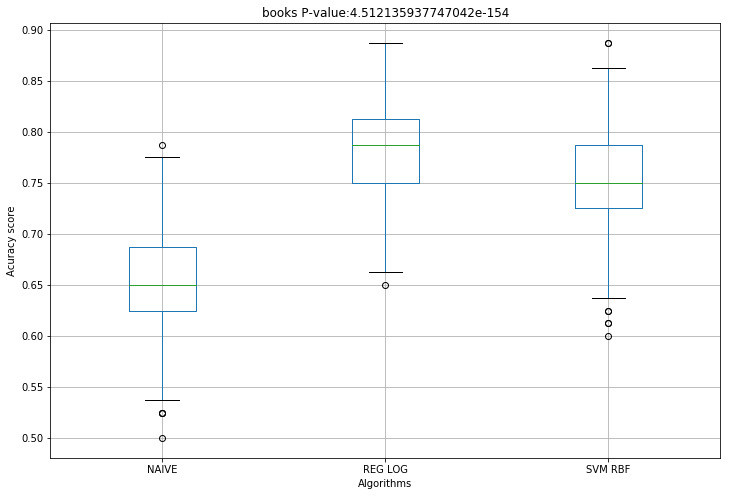

In [37]:

ite = 50
kvalue = 10
kseed = 1

# CADA UM DOS EXPERIMENTOS É REALIZADO COM UMA BASE DE DADOS, SÓ DESCOMENTAR PRA TESTAR COM A OUTRA

naivematrix,logmatrix,svmmatrix = kfoldexperiment(kvalue,kseed,ite,books[0],books[1],'books')
#naivematrix,logmatrix,svmmatrix = kfoldexperiment(kvalue,kseed,ite,dvd[0],dvd[1],'dvd')
#naivematrix,logmatrix,svmmatrix = kfoldexperiment(kvalue,kseed,ite,elec[0],elec[1],'electronics')
#naivematrix,logmatrix,svmmatrix = kfoldexperiment(kvalue,kseed,ite,kitchen[0],kitchen[1],'kitchen')
